# **Introduction**

## **"Can we build a workplace culture where mental health is not just tolerated, but actively protected?"**
Mental health remains underreported, stigmatized, and poorly integrated into workplace policies—especially in the tech industry. Yet its impact on productivity, retention, and employee well-being is undeniable.

This project uses survey data stored in a SQLite database to analyze mental health prevalence, demographic risk factors, and the effects of disclosure in professional settings. By combining **quantitative trends with personal experiences, it aims to inform more empathetic, evidence-based workplace policies.**

### **Main objectives:**
1. **Map the dataset** – Identify key tables and variables, clean the data using SQL and Pandas.

2. **Profile respondents** – Understand demographic breakdown (e.g., gender, age, job role, race).

3. **Detect sampling bias** – Evaluate representation across different groups.

4. **Analyze mental health trends** – Estimate prevalence of key conditions like anxiety, depression, and ADHD.

5. **Study influencing factors** – Explore how variables such as age, gender, and position relate to mental health risk.

6. **Assess disclosure impact** – Analyze how revealing a mental health issue affects workplace relationships and career progression.

7. **Evaluate perceived support** – Examine how respondents view industry support for mental health.

Using Pandas and NumPy for data manipulation, and Seaborn, Matplotlib for expressive visualizations, I will conduct thorough exploratory data analysis (EDA). The findings aim to **highlight mental health trends, reveal disparities, and support it with vivid data illustrations based on data-driven insights to raise awareness of mental health in organizations**.

*Importing necessities:*

In [75]:
!pip install statsmodels

import os
import sqlite3
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import statsmodels.stats.proportion as smprop

%matplotlib inline



*Dataset Structure:*

In [76]:
print("Exists:", os.path.exists("mental_health.sqlite"))
print("File size (KB):", os.path.getsize("mental_health.sqlite") / 1024)

conn = sqlite3.connect("/content/mental_health.sqlite")

query = "SELECT name FROM sqlite_master WHERE type='table';"
tables = pd.read_sql(query, conn)

print("Tables in DB:")
print(tables)


Exists: True
File size (KB): 5752.0
Tables in DB:
       name
0    Answer
1  Question
2    Survey


## **1. Tables Overview - to learn about the structure of given dataset.**

In [77]:
for table in tables["name"]:
    print(f"\nTable: {table}")

    df_preview = pd.read_sql(f"SELECT * FROM {table}", conn)
    print(df_preview.head())

    print(f"\nColumns: {df_preview.columns.tolist()}")
    print('-' * 50)



Table: Answer
  AnswerText  SurveyID  UserID  QuestionID
0         37      2014       1           1
1         44      2014       2           1
2         32      2014       3           1
3         31      2014       4           1
4         31      2014       5           1

Columns: ['AnswerText', 'SurveyID', 'UserID', 'QuestionID']
--------------------------------------------------

Table: Question
                                        questiontext  questionid
0                                  What is your age?           1
1                               What is your gender?           2
2                       What country do you live in?           3
3  If you live in the United States, which state ...           4
4                             Are you self-employed?           5

Columns: ['questiontext', 'questionid']
--------------------------------------------------

Table: Survey
   SurveyID                    Description
0      2014  mental health survey for 2014
1      2016  me

The SQLite dataset contains three tables which include the sociodemographic features of respondents, the questions asked, and their answers over a five-year period.

## **2. Data Loading & Cleaning - prepare data for reliable and thorough analysis.**

### *Checking for NULL Values*

In [78]:
query = """
SELECT *
FROM Answer a
LEFT JOIN Question q ON a.QuestionID = q.QuestionID
LEFT JOIN Survey s ON a.SurveyID = s.SurveyID
WHERE
    a.UserID IS NULL OR
    a.QuestionID IS NULL OR
    a.SurveyID IS NULL OR
    a.AnswerText IS NULL OR
    q.QuestionID IS NULL OR
    q.QuestionText IS NULL OR
    s.SurveyID IS NULL OR
    s.Description IS NULL;
"""

null_values = pd.read_sql(query, conn)
null_values


Empty DataFrame
Columns: [AnswerText, SurveyID, UserID, QuestionID, questiontext, questionid, SurveyID, Description]
Index: []

In [79]:
query = """
WITH DeduplicatedAnswers AS (
    SELECT
        a.UserID,
        a.QuestionID,
        a.SurveyID,
        MIN(a.AnswerText) AS AnswerText  -- pick any one answer per user/question/year
    FROM Answer AS a
    GROUP BY a.UserID, a.QuestionID, a.SurveyID
),
Cleansed AS (
    SELECT
        CASE
            WHEN TRIM(da.UserID) = '' THEN 'Empty'
            ELSE TRIM(da.UserID)
        END AS user_id,
        CASE
            WHEN TRIM(da.QuestionID) = '' THEN 'Empty'
            ELSE TRIM(da.QuestionID)
        END AS question_id,
        CASE
            WHEN TRIM(q.questiontext) = '' THEN 'Empty'
            ELSE TRIM(q.questiontext)
        END AS question,
        CASE
            WHEN TRIM(da.AnswerText) = '' THEN 'Empty'
            ELSE TRIM(da.AnswerText)
        END AS answer,
        CASE
            WHEN TRIM(da.SurveyID) = '' THEN 'Empty'
            ELSE TRIM(da.SurveyID)
        END AS survey_year,
        CASE
            WHEN TRIM(s.Description) = '' THEN 'Empty'
            ELSE TRIM(s.Description)
        END AS description
    FROM DeduplicatedAnswers AS da
    LEFT JOIN Question AS q ON q.questionid = da.QuestionID
    LEFT JOIN Survey AS s ON da.SurveyID = s.SurveyID
),
Identify_missing_data AS (
    SELECT
        COALESCE(user_id, 'Unknown') AS user_id,
        COALESCE(question_id, 'Unknown') AS question_id,
        COALESCE(question, 'Unknown') AS question,
        COALESCE(answer, 'Unknown') AS answer,
        COALESCE(survey_year, 'Unknown') AS survey_year,
        COALESCE(description, 'Unknown') AS description,
        (
            CASE WHEN user_id = 'Empty' OR user_id = 'Unknown' THEN 1 ELSE 0 END +
            CASE WHEN question_id = 'Empty' OR question_id = 'Unknown' THEN 1 ELSE 0 END +
            CASE WHEN question = 'Empty' OR question = 'Unknown' THEN 1 ELSE 0 END +
            CASE WHEN answer = 'Empty' OR answer = 'Unknown' THEN 1 ELSE 0 END +
            CASE WHEN survey_year = 'Empty' OR survey_year = 'Unknown' THEN 1 ELSE 0 END +
            CASE WHEN description = 'Empty' OR description = 'Unknown' THEN 1 ELSE 0 END
        ) AS missing_data
    FROM Cleansed cl
)

SELECT
    main.user_id,
    main.question_id,
    main.question,
    main.answer,
    main.survey_year,
    main.description,
    COUNT(*) OVER (PARTITION BY main.user_id) AS total_answers_by_user,
    COUNT(*) OVER (PARTITION BY main.survey_year) AS total_answers_in_year,
    main.missing_data
FROM (
    SELECT
        user_id,
        question_id,
        question,
        answer,
        survey_year,
        description,
        missing_data
    FROM Identify_missing_data
) AS main
ORDER BY main.survey_year;
"""

final_df = pd.read_sql(query, conn)


## **3. Evaluation of Sociodemographic Features**

Exploring:
* Sample size
* Age distribution
* Gender identity
* Country of residence
* Race/ethnicity
* Work role
* IT-relatability of job

This investigation helps un**cover the composition and diversity of the survey sample**, identify any **potential demographic or geographic biases**, and establish context for interpreting **mental health trends across subpopulations**.




## General Overview
This section explores **basic characteristics** of the mental health survey dataset, including the **sample size, number of unique questions and responses** to provide a foundational understanding of the **data's scope and structure.**

In [80]:
print(f"Sample size of respondents: {final_df.user_id.nunique()}")

Sample size of respondents: 4218


In [81]:
print(f"Number of unique questions: {final_df.question_id.nunique()}")

Number of unique questions: 105


In [82]:
print(f"Overall number of responses: {final_df.answer.count()}")

Overall number of responses: 234640


In [83]:
color_palette = sns.color_palette("crest")

Number of respondents' answers each year:

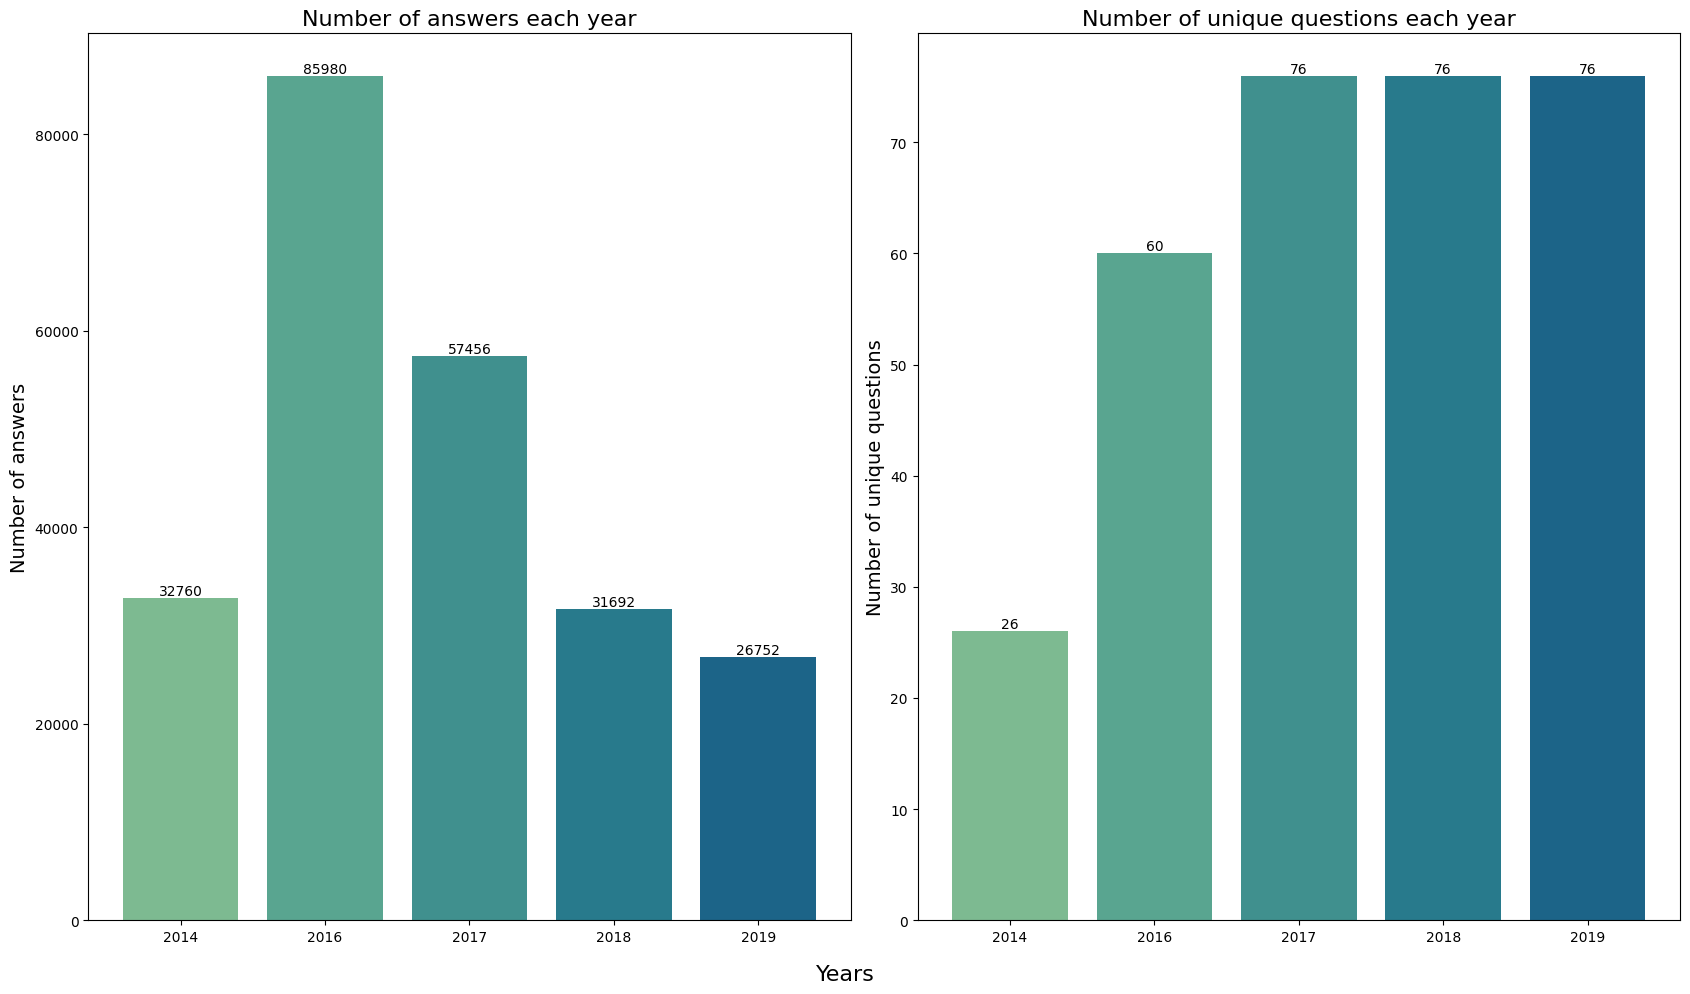

In [84]:
final_df.survey_year.value_counts().sort_values(ascending=False)

fig, axs = plt.subplots(1, 2, figsize=(17, 10))

survey_years_count = final_df.survey_year.value_counts().sort_index(ascending=True)
survey_years = survey_years_count.index
survey_years_count = survey_years_count.values

axs[0].bar(x=survey_years, height=survey_years_count, color=color_palette)
axs[0].bar_label(axs[0].containers[0])
axs[0].set_ylabel("Number of answers", fontsize=14)
axs[0].set_title("Number of answers each year", fontsize=16)

unique_questions_year_count = final_df.groupby('survey_year')['question'].nunique().sort_index(ascending=True)

axs[1].bar(x=survey_years, height=unique_questions_year_count, color=color_palette)
axs[1].bar_label(axs[1].containers[0])
axs[1].set_ylabel("Number of unique questions", fontsize=14)
axs[1].set_title("Number of unique questions each year", fontsize=16)

fig.supxlabel("Years", fontsize=16)

plt.tight_layout()


The survey saw its **highest participation and question diversity in 2016 and 2017, reflecting peak engagement**, likely driven by increased mental health awareness. However, from **2017 to 2019, participation declined rapidly**, suggesting **a drop in outreach effectiveness, rising respondent fatigue, or waning relevance**. Despite this, the number of singular answers remained stable, indicating consistent depth among remaining participants.

## Age & Gender & Country & Race Features
These **demographic features** help us understand who is represented in the survey. By analyzing age, gender,race and country, we can assess the diversity of the sample, identify **potential regional or cultural patterns in mental health conditions**, and detect any **demographic imbalances or biase**s in the data.

## *Age Data*

In [85]:
age = final_df.query("question == 'What is your age?'")
age.answer = age.answer.astype(int)

gender = final_df.query("question == 'What is your gender?'")

country = final_df.query("question == 'What country do you live in?'")

race = final_df.query("question == 'What is your race?'")


<ipython-input-85-4ff1bc30934e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age.answer = age.answer.astype(int)


Calculating outliers for age feature to avoid data distortion:

<ipython-input-86-50bf039e1182>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-86-50bf039e1182>:15: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(
<ipython-input-86-50bf039e1182>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
<ipython-input-86-50bf039e1182>:23: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.boxplot(


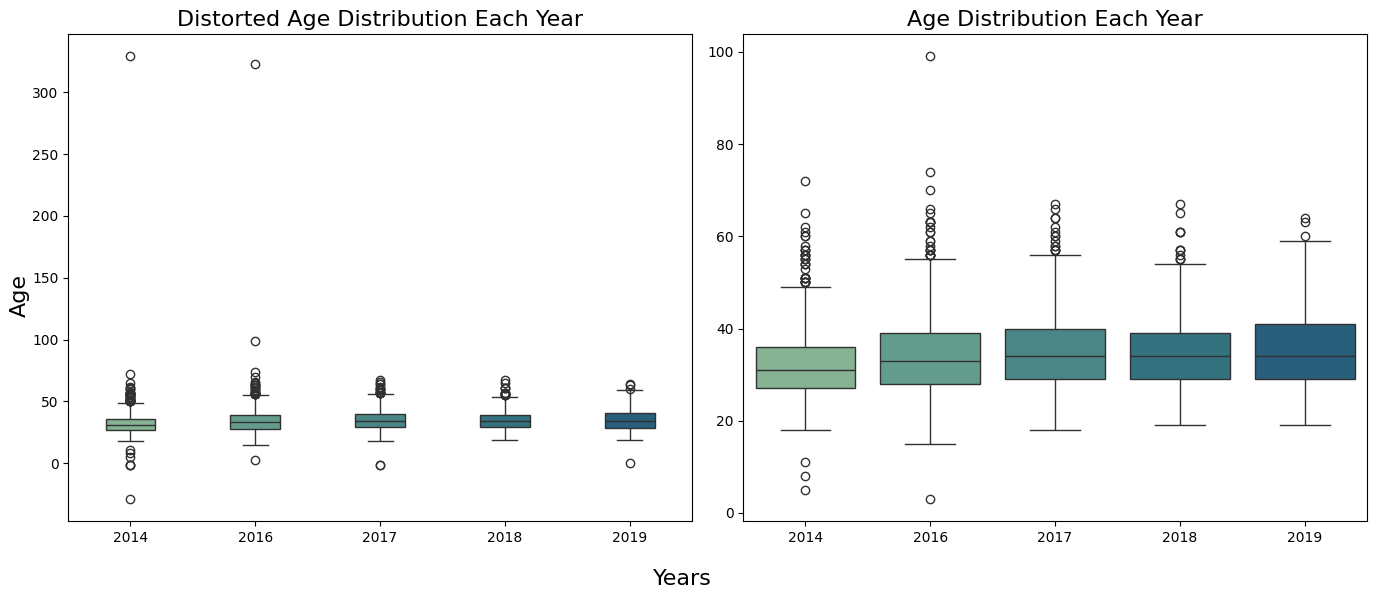

In [86]:
age_without_outliers = age.answer.apply(
    lambda x: age.answer.median() if x <= 0 or x > 100 else x
)

age_data = final_df.copy()
age_data = pd.merge(
    age_data, age_without_outliers.rename('age_without_outliers'),
    left_index=True, right_index=True, how='left'
)

final_boxplot_data = age_data[["survey_year", 'age_without_outliers']]

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

sns.boxplot(
    x=age.survey_year, y=age.answer, width=0.4, dodge=False, ax=axs[0],
    palette=color_palette
)
axs[0].set_title("Distorted Age Distribution Each Year", fontsize=16)
axs[0].set_xlabel("")
axs[0].set_ylabel("")

sns.boxplot(
    x="survey_year", y="age_without_outliers", data=final_boxplot_data,
    ax=axs[1], palette=color_palette
)
axs[1].set_title("Age Distribution Each Year", fontsize=16)
axs[1].set_xlabel("")
axs[1].set_ylabel("")

fig.supxlabel("Years", fontsize=16)
fig.supylabel("Age", fontsize=16)

plt.tight_layout()


Looking at the graphs above, it is clear that the **age data is positively skewed due to irrational responses** (e.g., ages below 0 or above 100).
However, after filtering out these outliers, it becomes apparent that the **majority of survey respondents are between their early and late 30s,** with a consistent **median age around 36** across all years.

## *Gender Data*

Gender values categorization into less subgroups to optimize future analysis results and identify trends more clearly:

In [87]:
def gender_cleansing(value):
    """
    Normalizes free-text gender responses into consistent labels that are easier to analyze statistically and visualize.

    :param value: gender value to be filtered out
    :type value: str
    :return: normalized gender labels
    :rtype: str
    """
    val = str(value).strip().lower()

    if val in ['male', 'm', 'cis male', 'man', 'male-ish', 'guy (-ish) ^_^',
               'ostensibly male', 'male 9:1 female, roughly', 'MALE', 'cishet male']:
        return 'Male'

    elif val in ['female', 'f', 'cis female', 'woman', 'fm', 'female-ish', 'female assigned at birth',
                 'female/gender non-binary.', 'female-bodied; no feelings about gender']:
        return 'Female'

    elif 'trans' in val or 'mtf' in val or 'ftm' in val or 'transitioned' in val:
        return 'Transgender'

    elif any(keyword in val for keyword in [
        'non-binary', 'nonbinary', 'enby', 'genderqueer', 'genderfluid',
        'androgynous', 'agender', 'bigender', 'nb', 'demi', 'fluid', 'queer'
    ]):
        return 'Non-binary'

    elif val in ['none', 'nah', 'n/a', '43', 'rr', 'none of your business', 'contextual',
                 'a little about you', 'i have a penis', 'i am a wookie', 'god king of the valajar']:
        return 'Other'

    elif val == '-1':
        return 'Unknown'
    else:
        return 'Other'


In [88]:
cleaned_gender = gender

cleaned_gender.answer = cleaned_gender.answer.apply(gender_cleansing)

<ipython-input-88-3f37354cbd1e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_gender.answer = cleaned_gender.answer.apply(gender_cleansing)


## *Country Data*

There are duplicated values, incoherent values found in countries presented in the dataset that might lead to unrealiable results. That's why it's crucial to refine the values to avoid bias.

In [89]:
cleaned_countries = country['answer'].replace({
    'United States': 'United States of America',
    '-1': 'Unknown',
    'Bahamas, The': 'The Bahamas'
}).reset_index().rename(columns={'index': 'user_id'})


Isolation of high-frequency countries:

In [90]:
country_counts = cleaned_countries.answer.value_counts()

popular_countries = country_counts[country_counts > 50]

<ipython-input-91-e65da6acd818>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='answer', data=cleaned_gender, order=order, palette=color_palette, ax=axs[0])
<ipython-input-91-e65da6acd818>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='answer', x='count', data=popular_countries, ax=axs[1], palette=color_palette)
<ipython-input-91-e65da6acd818>:12: UserWarning: 
The palette list has fewer values (6) than needed (8) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(y='answer', x='count', data=popular_countries, ax=axs[1], palette=color_palette)


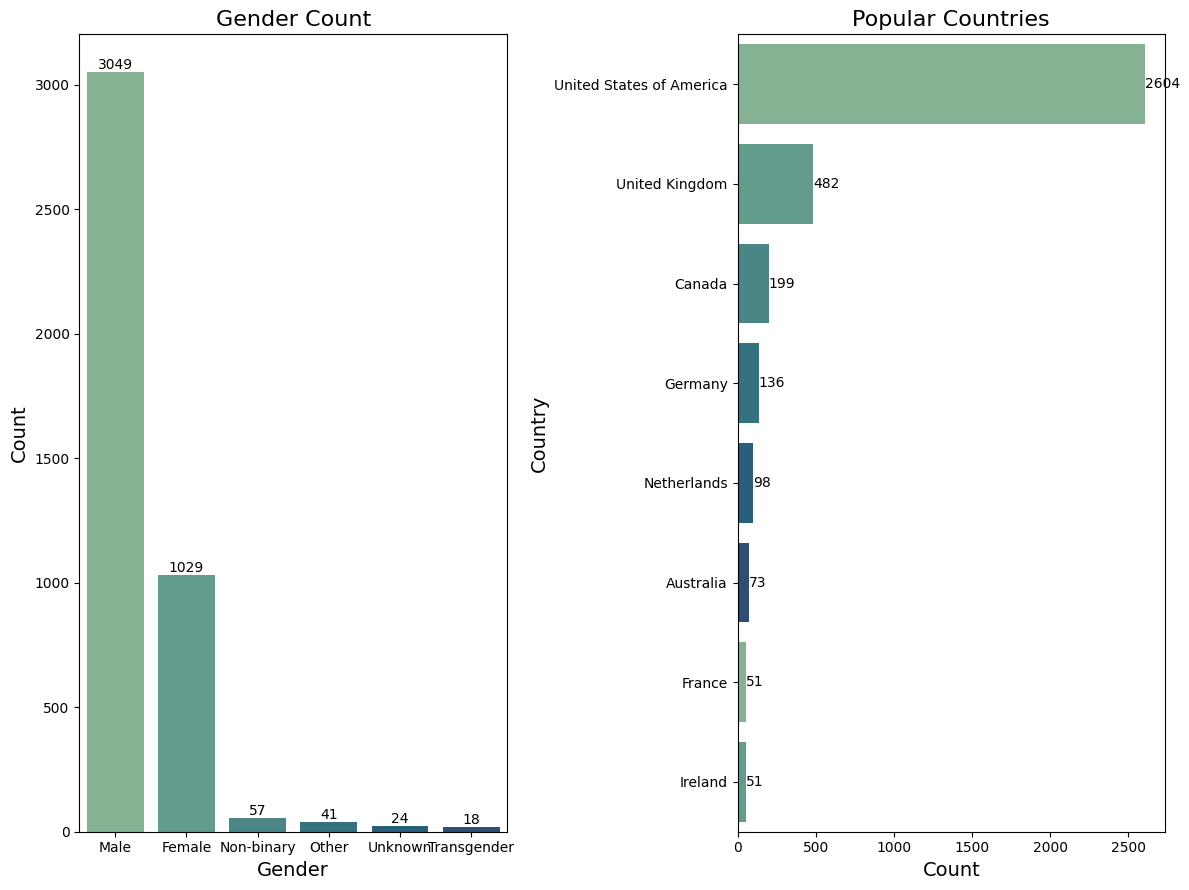

In [91]:
popular_countries = popular_countries.reset_index()
fig, axs = plt.subplots(1, 2, figsize=(12, 9))

order = cleaned_gender['answer'].value_counts().index
sns.countplot(x='answer', data=cleaned_gender, order=order, palette=color_palette, ax=axs[0])
for container in axs[0].containers:
    axs[0].bar_label(container, fmt='%d')
axs[0].set_xlabel("Gender", fontsize=14)
axs[0].set_ylabel("Count", fontsize=14)
axs[0].set_title("Gender Count", fontsize=16)

sns.barplot(y='answer', x='count', data=popular_countries, ax=axs[1], palette=color_palette)
for container in axs[1].containers:
    axs[1].bar_label(container, fmt='%d')
axs[1].set_ylabel("Country", fontsize=14)
axs[1].set_xlabel("Count", fontsize=14)
axs[1].set_title("Popular Countries", fontsize=16)

plt.tight_layout()



The data mapping indicates that most participants are from the **USA, UK, and Canada**, with **males and females** making up the **highest proportions**.

## *Race Data*

Race property filtering for more consistent and reliable outcomes:

In [92]:
cleaned_race = race.replace({
    "-1": "Unknown",
    "More than one of the above": "Other",
    "I prefer not to answer": "Other"
})

Number of participants of various etnicities:

In [93]:
cleaned_race.answer.value_counts()

answer
White                               873
Unknown                             537
Other                                64
Asian                                31
Black or African American            15
American Indian or Alaska Native      1
Hispanic                              1
White Hispanic                        1
European American                     1
Caucasian                             1
Name: count, dtype: int64

The data suggests that the majority of survey respondents identify as **White**, followed by those categorized as **Unknown/Other and Asian**.

## *Work position & IT job relatabiity*
These features help us understand the **professional background** of the survey takers and whether their **roles are related/not related to the tech industry.**

Merging data for optimization:

In [94]:
role_data = final_df[final_df.question == 'Which of the following best describes your work position?'][['user_id', 'answer']]
gender_data = cleaned_gender[cleaned_gender.question == 'What is your gender?'][['user_id', 'answer']]
remotely_data = final_df[final_df.question == 'Do you work remotely?'][['user_id', 'answer']]
it_relatability_data = final_df.query("question == 'Is your primary role within your company related to tech/IT?'")[['user_id', 'answer']]

role_data, gender_data, remotely_data, it_relatability_data = [
    role_data.rename(columns={'answer': 'role'}),
    gender_data.rename(columns={'answer': 'gender'}),
    remotely_data.rename(columns={'answer': 'remotely'}),
    it_relatability_data.rename(columns={'answer': 'it_relatability'})
]

merged_data = role_data
for df in [gender_data, remotely_data, it_relatability_data]:
    merged_data = pd.merge(merged_data, df, on='user_id', how='left')


Text(50.7222222222222, 0.5, 'Work Role')

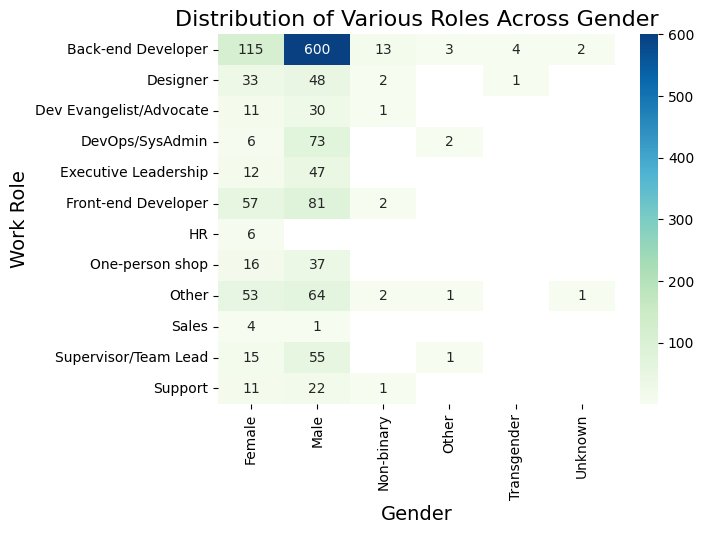

In [95]:
role_gender = merged_data.groupby(['role', 'gender']).size().unstack()
sns.heatmap(role_gender, annot=True, fmt='g', cmap='GnBu')
plt.title("Distribution of Various Roles Across Gender",fontsize=16)
plt.xlabel("Gender",fontsize=14)
plt.ylabel("Work Role",fontsize=14)


Results from the quantitative display indicate that the **majority of participants work in IT-related fields**. **Male respondents are the most represented, followed by females and non-binary individuals.**

---



---



<ipython-input-96-1137d2ae96aa>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='role', data=role_counts, ax=axs[0], palette=color_palette)
<ipython-input-96-1137d2ae96aa>:7: UserWarning: 
The palette list has fewer values (6) than needed (12) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='count', y='role', data=role_counts, ax=axs[0], palette=color_palette)
<ipython-input-96-1137d2ae96aa>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='remotely', y='count', data=remote_work_counts, ax=axs[1], palette=color_palette)
<ipython-input-96-1137d2ae96aa>:16: UserWarning: The palette list has more values (6) than needed (3), which may not be intended

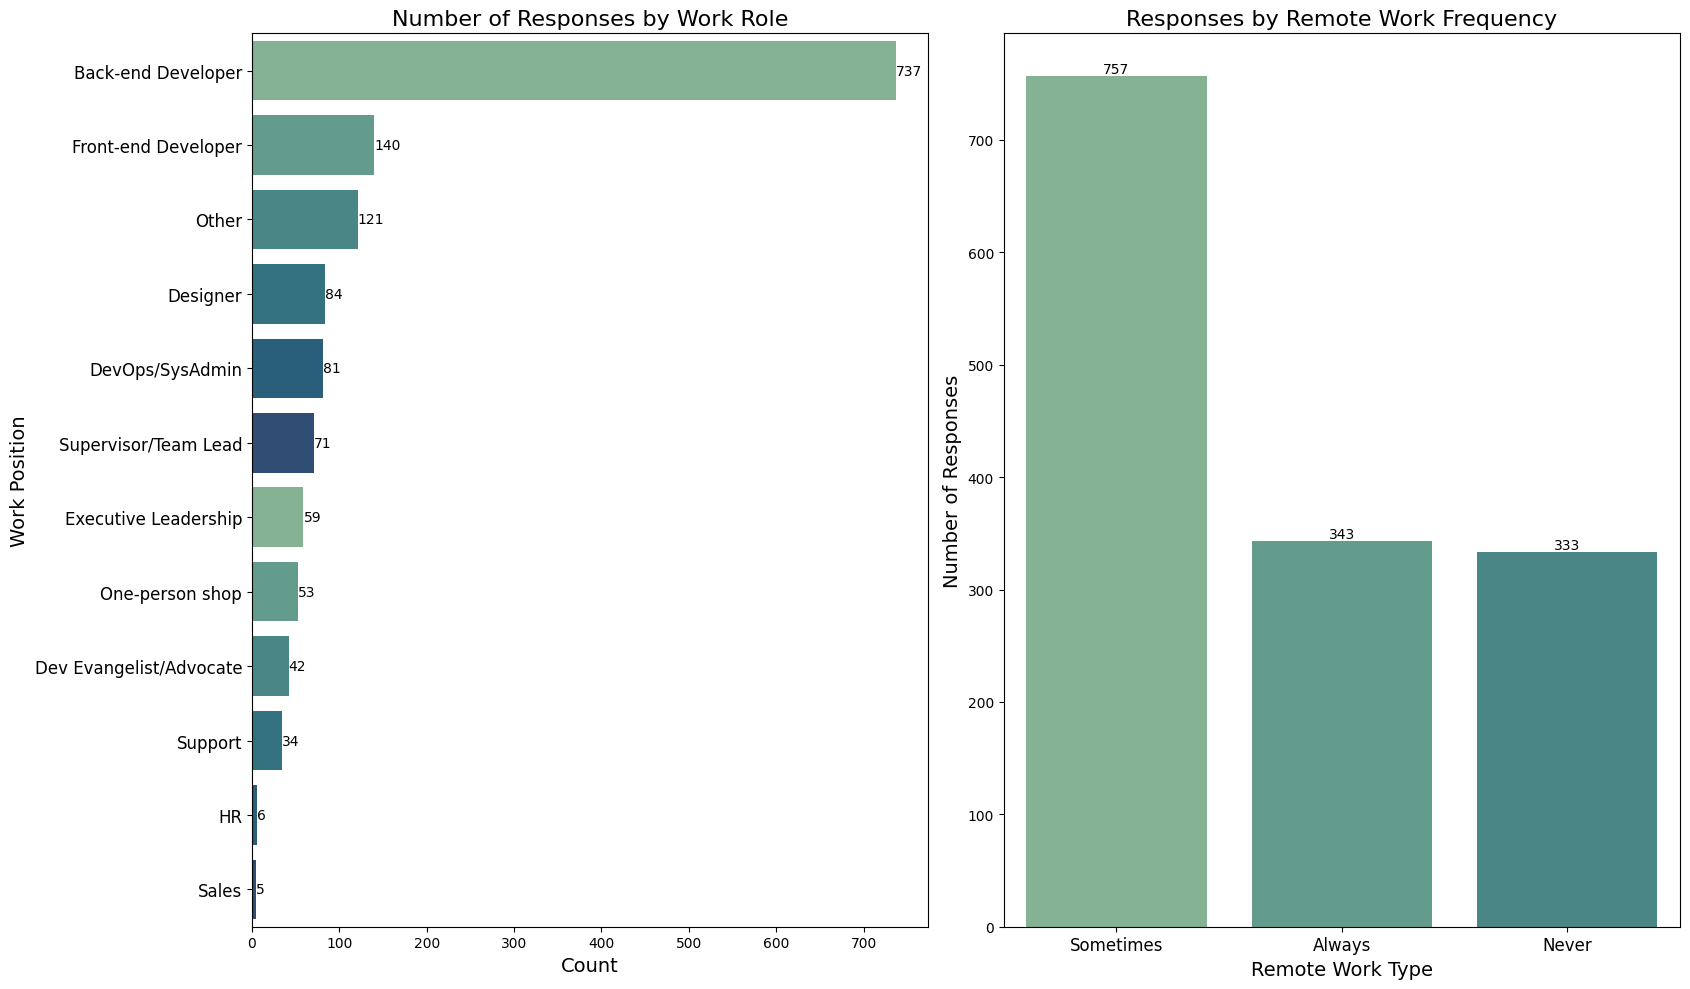

In [96]:
fig, axs = plt.subplots(1, 2, figsize=(17, 10))

role_overall_count = role_data.role.count()

role_counts = role_data['role'].value_counts().reset_index()
role_counts.columns = ['role', 'count']
sns.barplot(x='count', y='role', data=role_counts, ax=axs[0], palette=color_palette)
axs[0].set_title("Number of Responses by Work Role", fontsize=16)
axs[0].set_xlabel("Count", fontsize=14)
axs[0].set_ylabel("Work Position", fontsize=14)
axs[0].tick_params(axis='y', labelsize=12)
for bar in axs[0].containers:
    axs[0].bar_label(bar)

remote_work_counts = remotely_data['remotely'].value_counts().reset_index()
sns.barplot(x='remotely', y='count', data=remote_work_counts, ax=axs[1], palette=color_palette)
axs[1].set_title("Responses by Remote Work Frequency", fontsize=16)
axs[1].set_xlabel("Remote Work Type", fontsize=14)
axs[1].set_ylabel("Number of Responses", fontsize=14)
axs[1].tick_params(axis='x', labelsize=12)
for bar in axs[1].containers:
    axs[1].bar_label(bar)

fig.tight_layout()


A significant portion of respondents come from IT-related fields such as **back-end development, front-end development, and design.** The majority report working remotely at least part of the time, while the number of those who never work remotely and those who are fully remote is nearly equal. This pattern supports the conclusion that jobs in the **IT sector often offer flexibility for remote work**.

## **4. Mental Illness Diagnosis**

Exploring:
* **Family history of mental illness**
* **Current mental health disorders**
* **Self-reported/diagnosed impact of mental illness on productivity**

This section illustrates the prevalence and impact of mental health conditions among survey participants. It helps **identify risk factors**(e.g., family history), **current mental health status**, and how **mental illness affects work performance**.


Most popular disorders list:

In [97]:
disorders_list = ["Anxiety Disorder (Generalized, Social, Phobia, etc)",
                  "Mood Disorder (Depression, Bipolar Disorder, etc)",
                  "Attention Deficit Hyperactivity Disorder",
                  "Addictive Disorder",
                  "Post-traumatic Stress Disorder"]

In [98]:
fam_history = final_df[final_df.question=='Do you have a family history of mental illness?'][['user_id','answer']]
current_disorder = final_df[final_df.question=='Do you currently have a mental health disorder?'][['user_id','answer']]
disorder_type=final_df[final_df.question=='If yes, what condition(s) have you been diagnosed with?'][['user_id','answer']]
productivity=final_df[final_df.question=='Do you believe your productivity is ever affected by a mental health issue?'][['user_id','answer']]

Disorder type property wrangling to elude data inaccuracy:

In [99]:
cleaned_disorder_type = disorder_type.copy()
cleaned_disorder_type.replace('-1','Unknown',inplace=True)

cleaned_productivity = productivity.copy()
cleaned_productivity.replace('-1','Unknown',inplace=True)

Merging disorder data:

In [100]:
fam_history.columns = ['user_id', 'fam_history']
current_disorder.columns = ['user_id', 'current_disorder']
cleaned_disorder_type.columns = ['user_id', 'name_disorder']

dataframes = [fam_history, current_disorder, role_data, gender_data, remotely_data]
merged_disorder_data = cleaned_disorder_type.copy()

for df in dataframes:
    merged_disorder_data = pd.merge(merged_disorder_data, df, on='user_id', how='left')


Most frequent mental disorders among respondents:

In [101]:
disorder_type_count = cleaned_disorder_type.groupby('name_disorder').user_id.count()

filtered_disorder_counts = disorder_type_count[disorder_type_count > 5]

sorted_disorder_counts = filtered_disorder_counts.sort_values(ascending=False)


<ipython-input-102-9e2a9c055e77>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=sorted_disorder_counts,y=sorted_disorder_counts.index,palette=color_palette)


Text(0, 0.5, 'Mental Disorder')

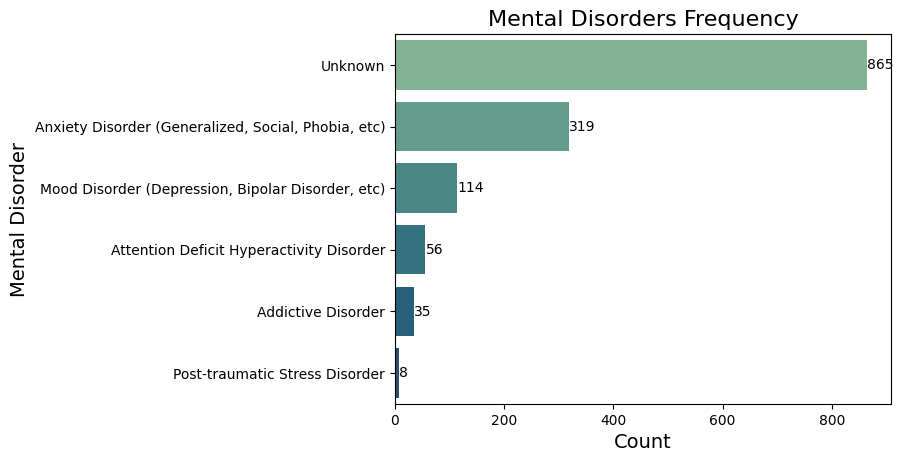

In [102]:
ax = sns.barplot(x=sorted_disorder_counts,y=sorted_disorder_counts.index,palette=color_palette)
for bar in ax.containers:
    ax.bar_label(bar)
plt.title("Mental Disorders Frequency",fontsize=16)
plt.xlabel("Count",fontsize=14)
plt.ylabel("Mental Disorder",fontsize=14)

To conclude data mapping above, most frequent mental conditions are:
1. Anxiety disorders
2. Mood mental challenges
3. Attention Deficit Hyperactivity issue
4. Addictive health concern
5. Post-Traumatic Stress Disorder

## **5. Family Disorder History VS Current Mental Ilness Exploration**
Evaluation of the link between having a family history of mental illness and the likelihood of an individual currently experiencing a mental health disorder. **This comparison aims to assess the potential influence of genetics and shared environmental factors on mental well-being.**

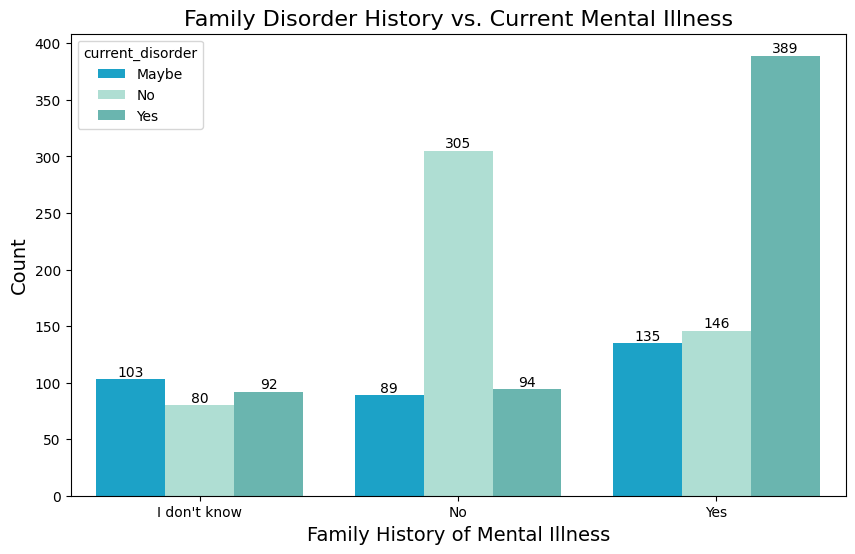

In [103]:
grouped_data = merged_disorder_data.groupby(['fam_history', 'current_disorder']).size().reset_index(name='count')

plt.figure(figsize=(10, 6))
ax = sns.barplot(x='fam_history', y='count', hue='current_disorder', data=grouped_data,palette=["#00B2E3", "#A7E6D7", "#5DC1B9"])

plt.xlabel("Family History of Mental Illness",fontsize=14)
plt.ylabel("Count",fontsize=14)
plt.title("Family Disorder History vs. Current Mental Illness",fontsize=16)

for container in ax.containers:
    ax.bar_label(container)


This data visualization suggests that **participants with a family history of mental illness are more likely to report having a mental health condition themselves** — in fact, they represent the largest group in the dataset. While respondents without a family history of mental illness also show notable numbers, the contrast highlights a potential **connection between genetic or familial factors** and the likelihood of experiencing mental health issues.

## **6. Different Disorders between males and females**
Mental health conditions often manifest differently across gender groups due to biological, social, and cultural factors. This analysis helps identify:

* **Which disorders are more commonly reported by certain genders.**

* **Whether any gender is underrepresented or shows unusually high prevalence.**

<ipython-input-104-131805a8e837>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='name_disorder', x='count', data=grouped_data[grouped_data['gender'] == 'Male'],
<ipython-input-104-131805a8e837>:17: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns.barplot(y='name_disorder', x='count', data=grouped_data[grouped_data['gender'] == 'Male'],
<ipython-input-104-131805a8e837>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='name_disorder', x='count', data=grouped_data[grouped_data['gender'] == 'Female'],
<ipython-input-104-131805a8e837>:26: UserWarning: The palette list has more values (6) than needed (5), which may not be intended.
  sns

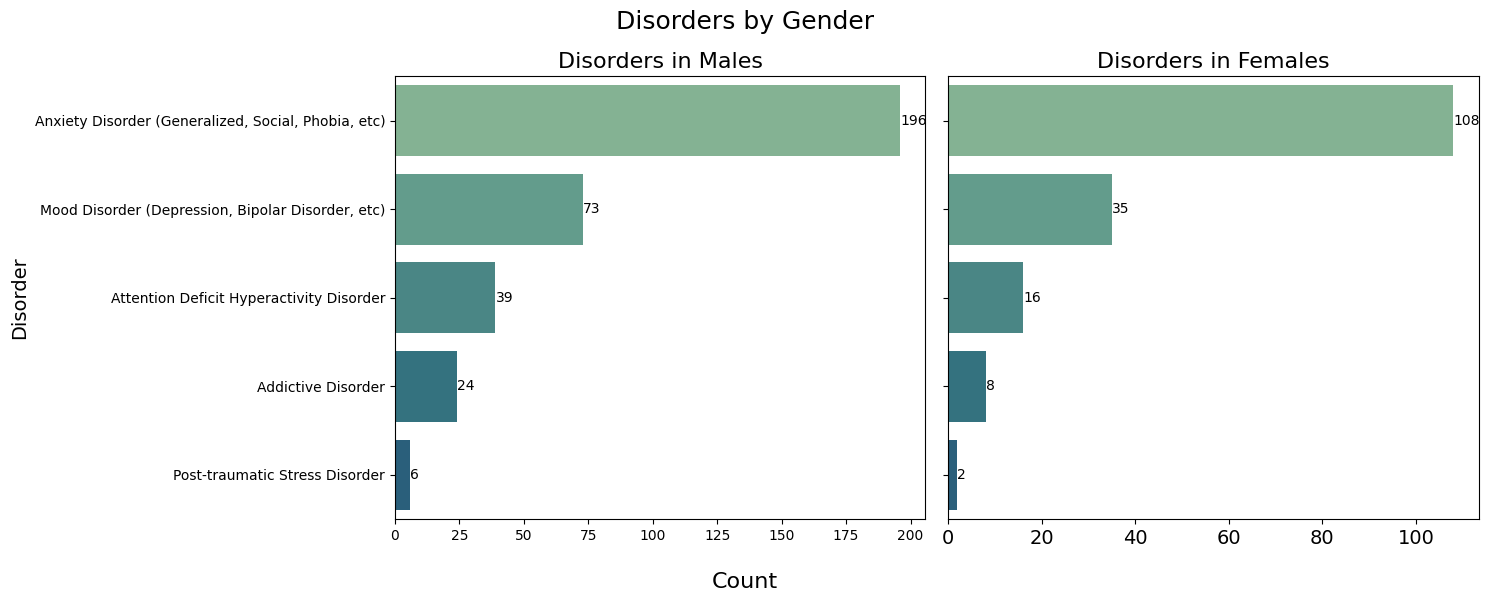

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

disorder_genders = ["Male", "Female"]

filtered_data = merged_disorder_data[
    (merged_disorder_data['gender'].isin(disorder_genders)) &
    (merged_disorder_data['name_disorder'].isin(disorders_list))
]

grouped_data = filtered_data.groupby(['gender', 'name_disorder']).size().reset_index(name='count')

disorder_order = grouped_data.groupby('name_disorder')['count'].sum().sort_values(ascending=False).index.tolist()

fig, axs = plt.subplots(1, 2, figsize=(15, 6), sharey=True)

sns.barplot(y='name_disorder', x='count', data=grouped_data[grouped_data['gender'] == 'Male'],
            ax=axs[0], order=disorder_order,palette=color_palette)
for bar in axs[0].containers:
    axs[0].bar_label(bar)
axs[0].set_title('Disorders in Males',fontsize=16)
axs[0].set_xlabel("")
axs[0].set_ylabel('Disorder',fontsize=14)


sns.barplot(y='name_disorder', x='count', data=grouped_data[grouped_data['gender'] == 'Female'],
            ax=axs[1], order=disorder_order,palette=color_palette)
for bar in axs[1].containers:
    axs[1].bar_label(bar)
axs[1].set_title('Disorders in Females',fontsize=16)
axs[1].set_xlabel("")
axs[1].set_ylabel('')
axs[1].tick_params(axis='x', labelsize=14)

fig.suptitle('Disorders by Gender', fontsize=18)
fig.supxlabel('Count', fontsize=16)



plt.tight_layout()


The quantitative analysis supports the observation that the most frequently reported mental **health conditions are more prevalent among males than females**, with **anxiety emerging as the most commonly reported disorder**.

## **7. Work Position VS Current Mental Ilness**
This analysis helps us understand how the **prevalence of mental health disorders** differs across various job roles, which can uncover **work-related factors** contributing to **mental health challenges.**

* **Identify job types with higher mental health burdens.**

* **Examine whether high-pressure roles correlate with specific disorders like anxiety, etc..**

In [105]:
filtered_data = merged_disorder_data[
    (merged_disorder_data['name_disorder'].isin(disorders_list)) &
    (merged_disorder_data['current_disorder'] == 'Yes')
]

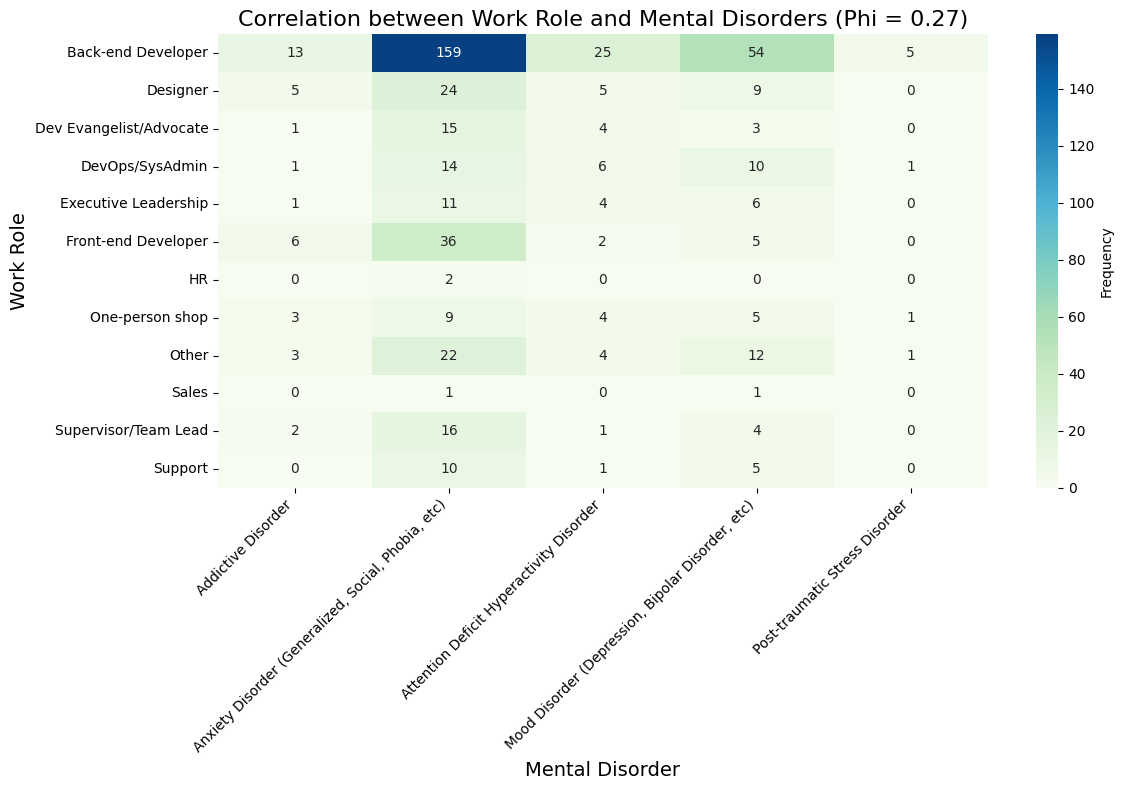

Phi Coefficient (Correlation): 0.27


In [106]:
contingency_table = pd.crosstab(filtered_data['role'], filtered_data['name_disorder'])

chi2, p, dof, expected = chi2_contingency(contingency_table)
phi = np.sqrt(chi2 / contingency_table.sum().sum())

plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, annot=True, fmt="d", cmap="GnBu",
            cbar_kws={'label': 'Frequency'})
plt.title(f"Correlation between Work Role and Mental Disorders (Phi = {phi:.2f})",fontsize=16)
plt.xlabel("Mental Disorder",fontsize=14)
plt.ylabel("Work Role",fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

print(f"Phi Coefficient (Correlation): {phi:.2f}")

This data visualization indicates that the **most frequently reported mental health conditions—particularly anxiety**—are most common among **individuals in roles such as back-end and front-end development, design, and supervisory or team lead positions.** These roles may contribute to higher stress levels **due to increased responsibility, cognitive demands, and the nature of remote or hybrid work environments.**

## **8. Prevalence Chart**
A prevalence chart visually represents *how common specific mental health conditions are* within a surveyed population.
* **The chart helps quantify the proportion of respondents currently diagnosed with each disorder (e.g., anxiety, mood disorders, ADHD).**

* **This gives a baseline understanding of which conditions are most widespread.**

<ipython-input-111-941779f1fdfa>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '20.107134541313908' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_prev.loc[i, 'CI Lower'] = ci_low * 100
<ipython-input-111-941779f1fdfa>:20: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '24.41484731493173' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_prev.loc[i, 'CI Upper'] = ci_upp * 100
<ipython-input-111-941779f1fdfa>:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(
<ipython-input-111-941779f1fdfa>:26: UserWarning: The palette list has more values (6) than needed (5), which may not be intend

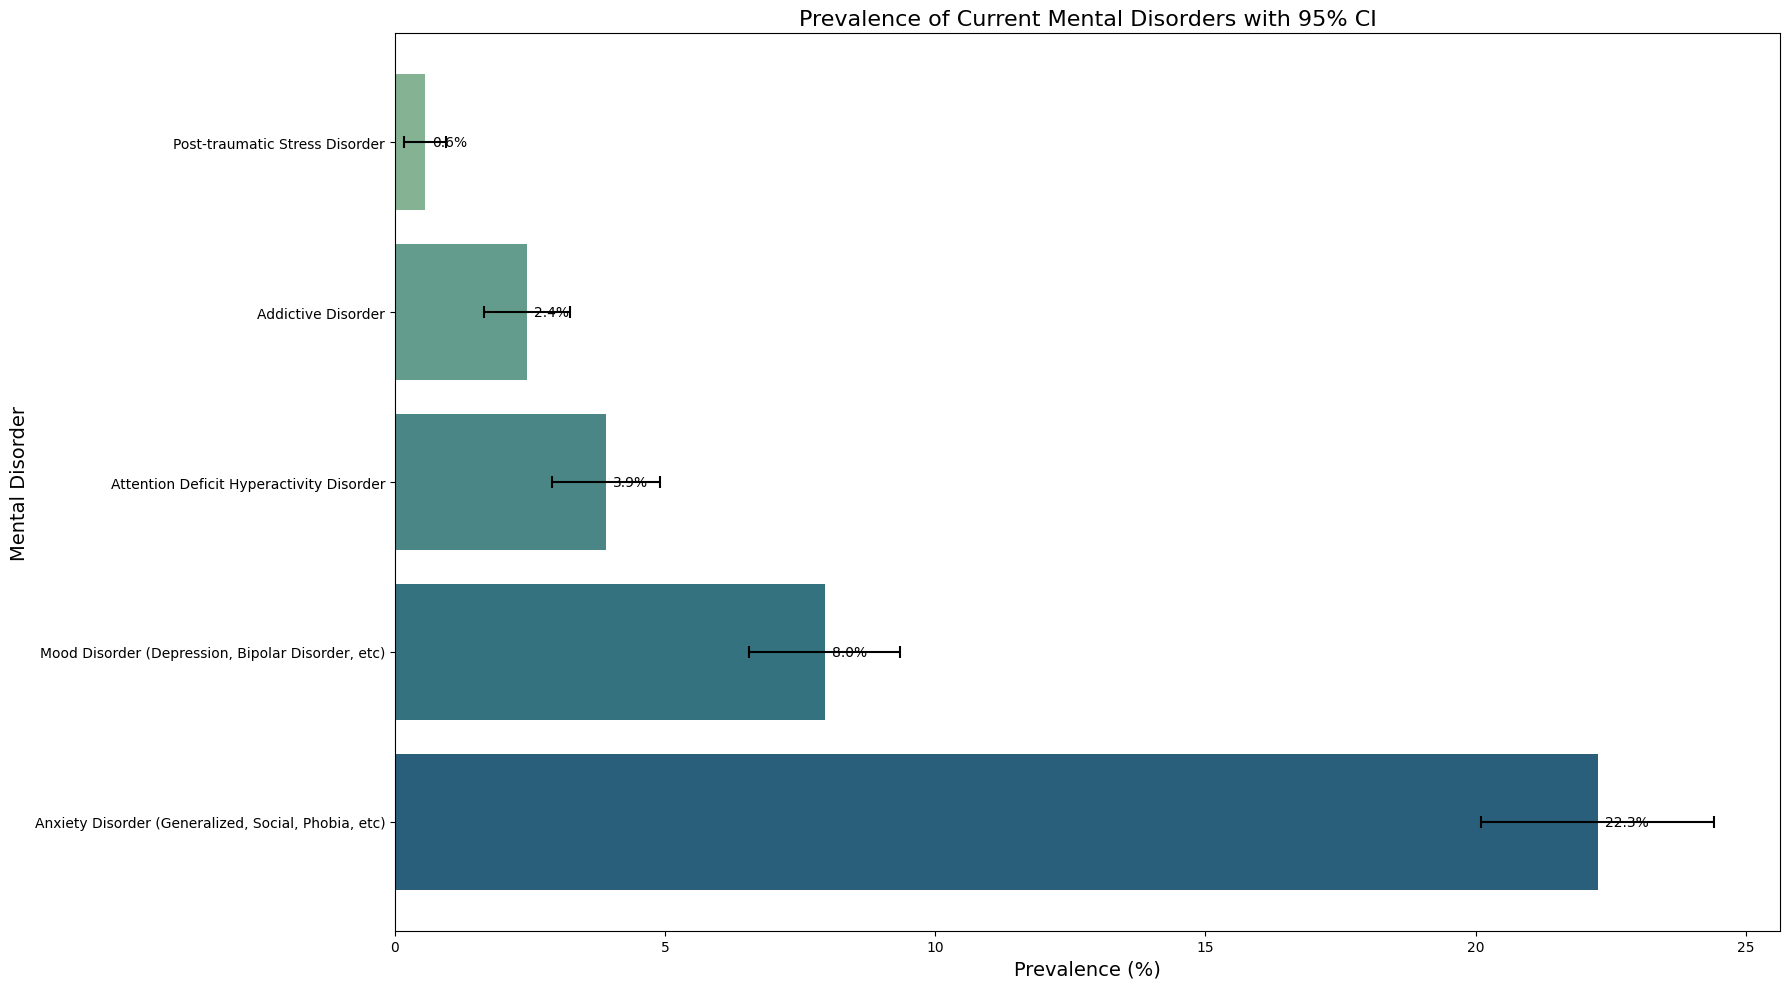

In [111]:
disorder_counts = merged_disorder_data['name_disorder'].value_counts()
total_respondents = merged_disorder_data['user_id'].nunique()

df_prev = pd.DataFrame({
    'Disorder': disorder_counts.index,
    'Count': disorder_counts.values
})

df_prev = df_prev[df_prev['Disorder'].isin(disorders_list)]

df_prev['Prevalence'] = (df_prev['Count'] / total_respondents) * 100

df_prev['CI Lower'] = 0
df_prev['CI Upper'] = 0
for i, row in df_prev.iterrows():
    ci_low, ci_upp = smprop.proportion_confint(
        row['Count'], total_respondents, method='normal'
    )
    df_prev.loc[i, 'CI Lower'] = ci_low * 100
    df_prev.loc[i, 'CI Upper'] = ci_upp * 100

order = df_prev.sort_values("Prevalence", ascending=True)["Disorder"]

plt.figure(figsize=(18, 10))

ax = sns.barplot(
    data=df_prev,
    y="Disorder",
    x="Prevalence",
    palette=color_palette,
    order=order
)


for container in ax.containers:
    ax.bar_label(container, fmt='%.1f%%', label_type='edge', padding=5)


for bar, (_, row) in zip(ax.patches, df_prev.set_index("Disorder").loc[order].iterrows()):
    bar_width = bar.get_width()
    bar_center = bar.get_y() + bar.get_height() / 2

    lower_error = bar_width - row["CI Lower"]
    upper_error = row["CI Upper"] - bar_width

    ax.errorbar(
        x=bar_width,
        y=bar_center,
        xerr=[[lower_error], [upper_error]],
        fmt='none',
        ecolor='black',
        capsize=4,
        capthick=1.5,
        elinewidth=1.5
    )

plt.xlabel("Prevalence (%)", fontsize=14)
plt.ylabel("Mental Disorder", fontsize=14)
plt.title("Prevalence of Current Mental Disorders with 95% CI", fontsize=16)
plt.tight_layout()

The bar chart displays the prevalence of current most frequent mental disorders among survey respondents. **Anxiety disorder is the most common (around 22%), followed by mood disorder (around 8%) and ADHD (around 3.9%).**



## **9. Remote work VS Mental Disorder**
This analysis investigates *how remote work status* (e.g., fully remote, hybrid, or on-site) relates to the prevalence of mental health disorders. It aims to explore whether different *work arrangements* are associated with *better or worse mental health outcomes*.

It aims to answer key question:

* **Do remote workers report higher or lower rates of mental illness compared to on-site workers?**




Text(50.72222222222219, 0.5, 'Mental Disorder')

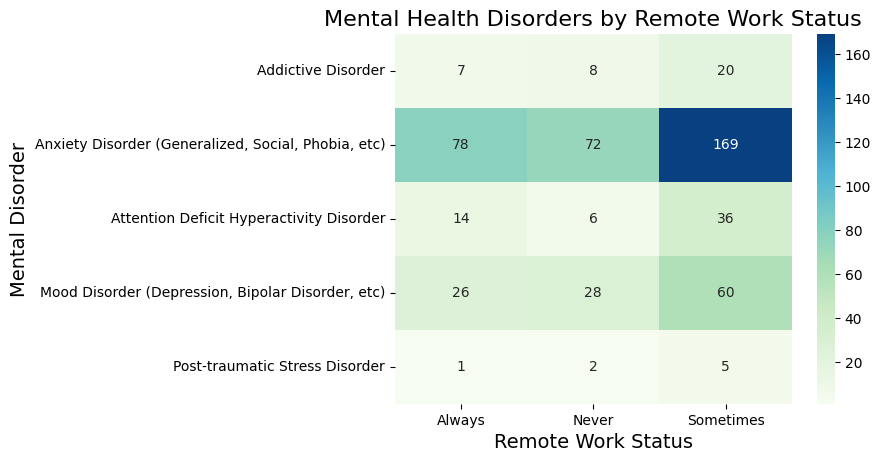

In [108]:
remote_disorder = merged_disorder_data[merged_disorder_data['name_disorder'].isin(disorders_list)].groupby(['name_disorder', 'remotely']).size().unstack()
sns.heatmap(remote_disorder, annot=True, fmt='g', cmap='GnBu')
plt.title("Mental Health Disorders by Remote Work Status",fontsize=16)
plt.xlabel("Remote Work Status",fontsize=14)
plt.ylabel("Mental Disorder",fontsize=14)


The chart suggests that individuals who work **partially or fully remotely exhibit a higher likelihood of experiencing a mental health condition**. The most frequently reported conditions among this group are **anxiety and attention deficit hyperactivity disorder (ADHD)**, indicating a **potential link between remote work environments and these specific mental health challenges**.

## **10. Possible Data Corruption**
While the analysis offers useful insights, **several limitations** should be noted. The **sample size may be too small(4218 respodents)** to generalize findings, especially for subgroups, and **inconsistent or incomplete responses** can skew results. Data issues like **typos or placeholder values (e.g., -1)** may also affect accuracy. Moreover, the dataset is **predominantly composed of male respondents(72.28%) from IT-related roles (e.g., front-end(51%)/back-end(10%) development, design(8%) based in the U.S(around 62%).,** introducing demographic and geographic bias. These factors warrant cautious interpretation of the results.

## **11. Mental Health Support**

In [109]:
questions = {
    "help": "Does your employer offer resources to learn more about mental health disorders and options for seeking help?",
    "support": "Have you observed or experienced supportive or well handled response to a mental health issue in your current or previous workplace?",
    "impact": "If you have revealed a mental health disorder to a coworker or employee, how has this impacted you or the relationship?"
}

dataframes = {}
counts = {}

for key, question in questions.items():
    df = final_df[final_df.question == question].copy()
    df['answer'].replace('-1', 'Unknown', inplace=True)
    dataframes[key] = df
    counts[key] = df['answer'].value_counts()



<ipython-input-109-2bc0069a02b8>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['answer'].replace('-1', 'Unknown', inplace=True)
<ipython-input-109-2bc0069a02b8>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', t

<ipython-input-110-cecf9266edc6>:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(counts["help"].index, rotation=45, ha='right')
<ipython-input-110-cecf9266edc6>:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(counts["support"].index, rotation=45, ha='right')
<ipython-input-110-cecf9266edc6>:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[2].set_xticklabels(counts["impact"].index, rotation=45, ha='right')


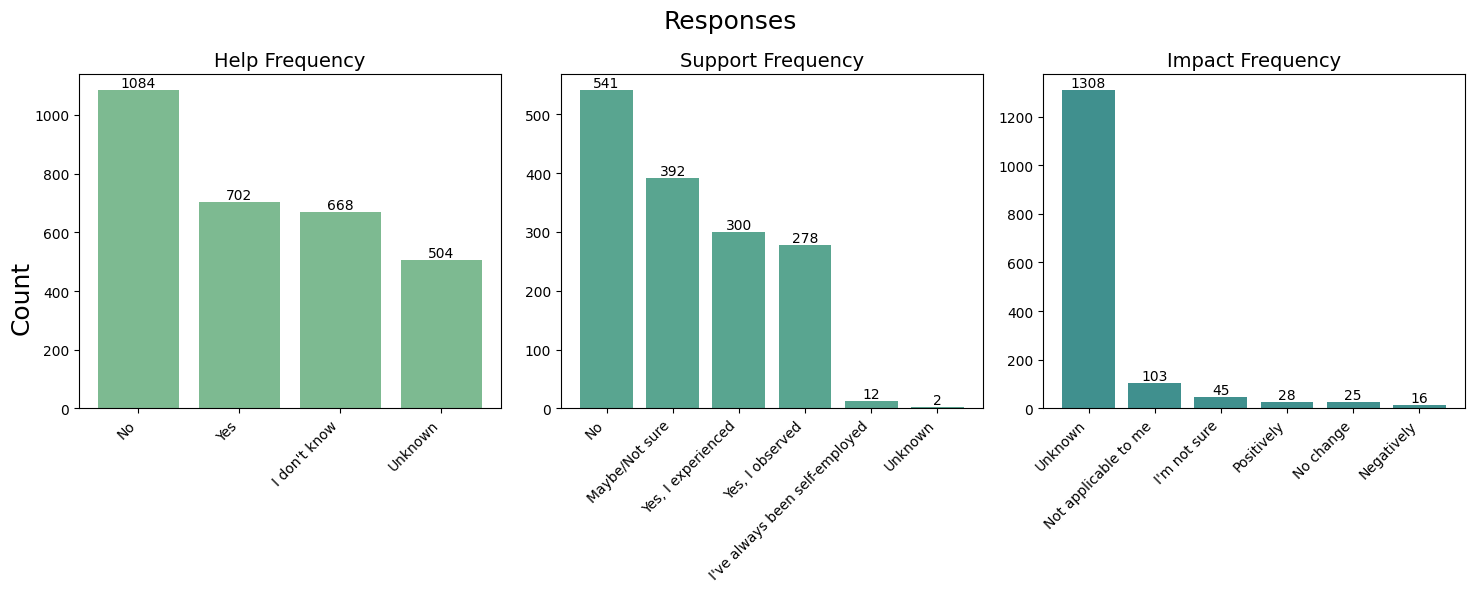

In [110]:
fig, axs = plt.subplots(1, 3, figsize=(15, 6))

axs[0].bar(counts["help"].index, counts["help"].values, color=color_palette[0])
axs[0].bar_label(axs[0].containers[0])
axs[0].set_title("Help Frequency",fontsize=14)
axs[0].set_xticklabels(counts["help"].index, rotation=45, ha='right')

axs[1].bar(counts["support"].index, counts["support"].values, color=color_palette[1])
axs[1].bar_label(axs[1].containers[0])
axs[1].set_title("Support Frequency",fontsize=14)
axs[1].set_xticklabels(counts["support"].index, rotation=45, ha='right')

axs[2].bar(counts["impact"].index, counts["impact"].values, color=color_palette[2])
axs[2].bar_label(axs[2].containers[0])
axs[2].set_title("Impact Frequency",fontsize=14)
axs[2].set_xticklabels(counts["impact"].index, rotation=45, ha='right')

fig.suptitle('Responses',fontsize=18)
fig.supylabel('Count',fontsize=18)
plt.tight_layout()

The analysis shows that most respondents said their **employers do not offer mental health resources**. Workplace responses were mixed, with **many reporting poor handling or uncertainty**. **Disclosure of mental health conditions often led to unknown change in relationships**, though some experienced positive or negative outcomes. These findings point to ongoing gaps and stigma in the tech industry.

# **12. Key Findings:**


### 1. **Widespread Challenges in Tech**
High mental health issue rates were reported by *back-end (51%), front-end (10%), designers (8%), and team leads (6%)*, linking mental strain to technical roles with **high demands** often associated with **long hours, cognitive strain, and constant deadlines**.

### **2. Remote Work Effects**
Those* working partially (53%) or fully remotely (24%)* reported **more mental health issues** than office workers, likely due to **isolation and blurred work-life boundaries**.

### **3. Anxiety, Depression, and ADHD Dominate**
These were the top reported conditions: *anxiety (319 cases), depression (114), and ADHD (56)*—highlighting key areas for **targeted support**.

### **4. Family History Matters**
*27% reported a family history of mental illnes*s, which strongly correlated with **personal mental health struggles**.This highlights the **genetic and environmental interplay** in mental health outcomes.

### **5. Employer Support Still Lacking**
**37%** said their employers *don’t provide mental health resources*. **61%** saw *poor or unclear responses to mental health issues*, and **93%** reported *no relationship change after disclosure*—showing **persistent stigma and limited engagement**.

### **6. Biased Sample**
The sample skewed **73%** *male and was mostly from USA, UK, and Canada,* **limiting generalizability beyond the tech-heavy Western context.**

### **7. Mental Health Is Systemic**
Patterns across roles, demographics, and conditions show *mental health in tech is structured and addressable* through **informed policy and support systems**.

# **Answer to Question**:
### "Can we build a workplace culture where mental health is not just tolerated, but actively protected?" -
Judging by the results building a workplace **culture that actively protects mental health is both necessary and achievable.**

The data shows high rates of mental **health issues in demanding tech roles and among remote workers, highlighting the need for structured support.** *Anxiety, depression, and ADHD were most common,* pointing to specific areas for intervention. Despite this, **most respondents reported a lack of employer resources and weak support systems.**


#### **To move beyond tolerance, companies must offer targeted resources, encourage open dialogue, and treat mental health as a core part of workplace well-being—not an afterthought.**

# **13. Possible Improvements**
#### 1. **Expand the sample size**
A larger and more diverse participant pool would *improve the reliability and generalizability of the findings.*

####  2. **Clean inconsistent or missing data**
Fixing placeholder values (e.g., "-1") and typos *enhances data accuracy and reduces noise in analysis.*

#### 3. **Collect additional variables**
*Adding factors* like job stress, workload, and access to care would *provide deeper insights into mental health drivers*.